In [1]:
import numpy as np
import torch
import pickle
import time
import os
%matplotlib inline
import matplotlib.pyplot as plt

import os
from pathlib import Path
os.chdir('../../') # go to root folder of the project
print(os.getcwd())
project_root = Path.cwd() / "data/molecules"
print(project_root) 

/home/zsy123/IMGT-MPN-main
/home/zsy123/IMGT-MPN-main/data/molecules


In [2]:
import pickle

%load_ext autoreload
%autoreload 2

from data.molecules import MoleculeDatasetDGL 

from data.data import LoadData
from torch.utils.data import DataLoader
from data.molecules import MoleculeDataset
from dgllife.utils import BaseAtomFeaturizer,WeaveAtomFeaturizer, CanonicalBondFeaturizer, smiles_to_bigraph, EarlyStopping


import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem



No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'sympy'
No module named 'sympy'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'sympy'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [4]:
df = pd.read_csv(project_root / 'ESOL/ESOL.csv')

In [6]:
import pandas as pd
from rdkit import Chem
from collections import defaultdict

# 用于存储所有不同原子类型和键类型的集合
atom_types = set()
bond_types = set()
df = pd.read_csv(project_root /'ESOL/ESOL.csv')


mol1 = Chem.MolFromSmiles('O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3')
if mol1 is None:
    print("mol is None")
else:
    print(mol1)

# 解析每个分子的 SMILES 字符串
for i, smiles in enumerate(df['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("number %s mol is None" % (i))
    if mol is not None:
        # 收集原子类型
        atom_types.update([atom.GetSymbol() for atom in mol.GetAtoms()])
        # 收集键类型
        bond_types.update([bond.GetBondType() for bond in mol.GetBonds()])

# 输出统计结果
print("Unique atom types:", atom_types)
print("Unique bond types:", bond_types)

num_atom_type = len(atom_types)
num_bond_type = len(bond_types)
print(num_atom_type)
print(num_bond_type)

mol is None
Unique atom types: {'F', 'N', 'Br', 'O', 'P', 'C', 'Cl', 'I', 'S'}
Unique bond types: {rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC}
9
4


In [7]:
import pandas as pd
from rdkit import Chem

# 从指定目录读取CSV文件
data_dir = project_root /'ESOL/ESOL'  # 替换为实际的数据目录
df = pd.read_csv(f'{data_dir}.csv')

# 初始化一个列表，用于存储有效的 SMILES 和相应的索引
valid_smiles = []
valid_indices = []

# 遍历每个 SMILES 字符串并检查其有效性
for i, smiles in enumerate(df['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        valid_smiles.append(smiles)
        valid_indices.append(i)

# 使用有效索引过滤 DataFrame
df_valid = df.iloc[valid_indices].reset_index(drop=True)

# 打印结果以验证
print(f"有效的SMILES条目数量: {len(df_valid)}")

# 如果你需要将处理后的 DataFrame 保存到新的 CSV 文件
df_valid.to_csv(f'{data_dir}_valid.csv', index=False)

有效的SMILES条目数量: 1128


In [8]:
DATASET_NAME = 'ESOL'
dataset = MoleculeDatasetDGL(DATASET_NAME) 

Time taken: 10.0296s


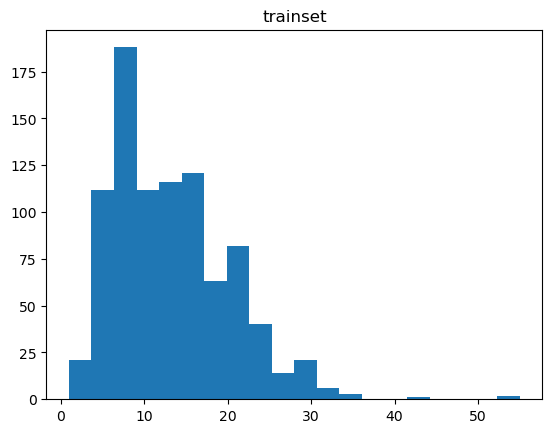

min/max : 1 55


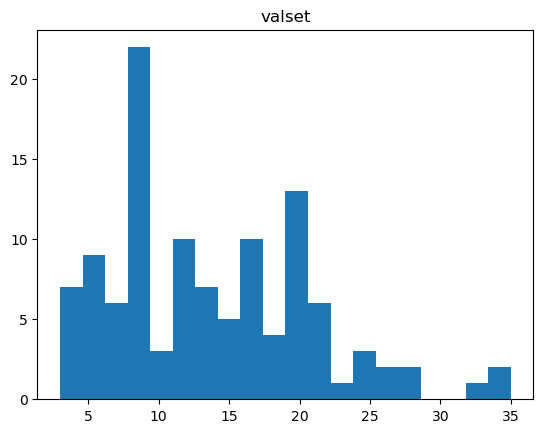

min/max : 3 35


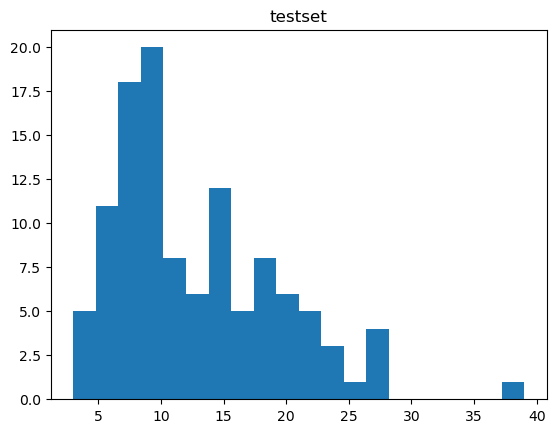

min/max : 3 39


In [9]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())
    
plot_histo_graphs(dataset.train,'trainset')
plot_histo_graphs(dataset.val,'valset')
plot_histo_graphs(dataset.test,'testset')

In [12]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])

# print(dataset.train[0][0].ndata['atom_type'])
# print(dataset.train[0][0].ndata['atom_type'].shape)
print(dataset.train[0][0].ndata['feat'].shape)


print(dataset.train.graph_labels)
print(dataset.val.graph_labels)
print(dataset.test.graph_labels)

print(sum(1 for label in dataset.train.graph_labels if label == 1))
print(sum(1 for label in dataset.val.graph_labels if label == 1))
print(sum(1 for label in dataset.test.graph_labels if label == 1))

902
113
113
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), -1.4)
(Graph(num_nodes=8, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), 0.7)
(Graph(num_nodes=14, num_edges=28,
      ndata_schemes={'feat': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), -2.57)
torch.Size([9, 27])
[-1.4, -0.39, -4.4, -2.676, -8.0, -5.752000000000001, -2.56, -7.39, -2.7, -6.237, -5.184, -3.35, -1.99, -1.4, -5.16, -2.82, -0.4, -3.638, -7.68, -4.55, -2.016, -1.3, -3.51, -1.29, -2.06, -7.32, -3.1710000000000003, -3.15, -5.03, -6.34, -1.87, -6.56, -3.04, -1.32, -2.44, -0.41, -4.04, -7.42, -6.005, -3.5380000000000003, -2.32, -4.173, -0.78, -3.6, -1.81, -3.12, -3.127, -1.74, -0.62, -4.871, -1.64, -3.03, -0.4, -3

In [13]:

start = time.time()
with open(project_root / 'ESOL/ESOL_8-1-1.pkl','wb') as f:
        pickle.dump([dataset.train,dataset.val,dataset.test,num_atom_type,num_bond_type],f)
print('Time (sec):',time.time() - start)

Time (sec): 0.46154332160949707


# Test load function

In [14]:
DATASET_NAME = 'ESOL'
dataset = LoadData(DATASET_NAME,2)
print(dataset)
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] 加载数据集 ESOL...
[I] 正在加载数据集 ESOL...
[I] 数据集 ESOL 加载成功
训练集大小: 902, 测试集大小: 113, 验证集大小: 113
[I] 数据加载完成，耗时: 0.3306s
[I] 成功加载数据集: ESOL
